In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#2 things we can do from here:

1. Running the conv_base over a dataset, and save the output. Pass this output as input to a standalone, densely connected classifier

2. Extending the model by adding Dense layers on top, and run the whole dataset

First method

In [29]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/My Drive/Image Datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

In [30]:
# extract features
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory,
                                          target_size=(150, 150),
                                          batch_size=batch_size,
                                          class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i+1) * batch_size] = features_batch
    labels[i * batch_size : (i+1) * batch_size] = labels_batch

    i+=1
    if i * batch_size >= sample_count:
      break
  
  return features, labels

In [31]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are of shape (samples, 4, 4, 512)
- to reshape them to (samples, 4 x 4 x 512)

In [32]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [33]:
# Densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))


Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6105 - acc: 0.6570 - val_loss: 0.4457 - val_acc: 0.8420
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4234 - acc: 0.8075 - val_loss: 0.3619 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3509 - acc: 0.8490 - val_loss: 0.3183 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3082 - acc: 0.8745 - val_loss: 0.2969 - val_acc: 0.8980
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2841 - acc: 0.8840 - val_loss: 0.2848 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2639 - acc: 0.8970 - val_loss: 0.2698 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2470 - acc: 0.8985 - val_loss: 0.2614 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

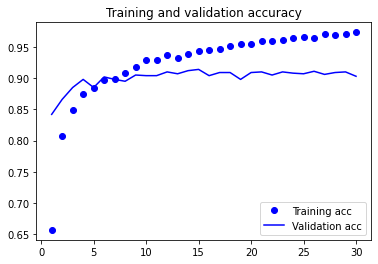

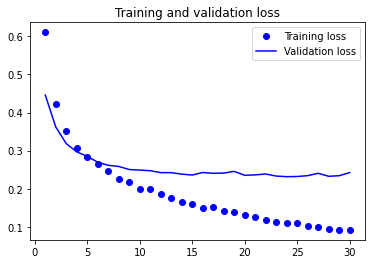

In [34]:
# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Second method

In [35]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

But before we compile and train the model, we should freeze the convolutional base to prevent the weights from being updated when the dense layers on top are being trained.

- setting its trainable attribute to False

In [36]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [37]:
# Start training model with the same data augmentation configuration

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should NOT be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150),
    batch_size=20, 
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 22s 215ms/step - loss: 0.5626 - acc: 0.7125 - val_loss: 0.4143 - val_acc: 0.8450
Epoch 2/30
100/100 [==============================] - 21s 215ms/step - loss: 0.4625 - acc: 0.7910 - val_loss: 0.3613 - val_acc: 0.8540
Epoch 3/30
100/100 [==============================] - 22s 217ms/step - loss: 0.4274 - acc: 0.8085 - val_loss: 0.3081 - val_acc: 0.8850
Epoch 4/30
100/100 [==============================] - 22s 215ms/step - loss: 0.3831 - acc: 0.8295 - val_loss: 0.2910 - val_acc: 0.8780
Epoch 5/30
100/100 [==============================] - 21s 214ms/step - loss: 0.3689 - acc: 0.8385 - val_loss: 0.2786 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 21s 214ms/step - loss: 0.3558 - acc: 0.8445 - val_loss: 0.2710 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 21s 212ms/step - loss: 0.3491 - acc: 0.8525 - val_lo

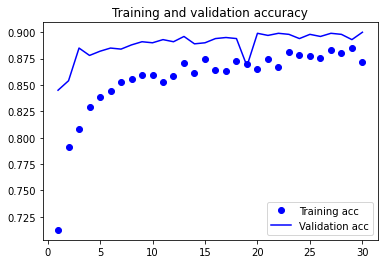

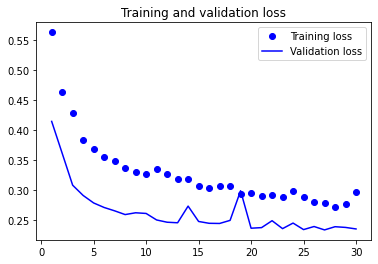

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

print("Accuracy: ", acc[-1])
print("Validation accuracy: ", val_acc[-1])
print("\n")
print("Loss: ", loss[-1])
print("Validation loss: ", val_loss[-1])

Accuracy:  0.8715000152587891
Validation accuracy:  0.8999999761581421


Loss:  0.2972235381603241
Validation loss:  0.23534834384918213


# Fine-tuning

We can fine tune the model by unfreezing the top layers of the conv base and retrain them, but the procedure should be like this:

1. Add your custom network on top of an already-trained base network
2. Freeze the base network
3. Train the part you added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part you added

In [40]:
# Looking at the base network once more
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [41]:
# We will train the block5_conv layers

conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [42]:
# Fine tune the network again
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 221ms/step - loss: 0.2994 - acc: 0.8750 - val_loss: 0.2295 - val_acc: 0.9020
Epoch 2/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2579 - acc: 0.8855 - val_loss: 0.2139 - val_acc: 0.9080
Epoch 3/100
100/100 [==============================] - 22s 222ms/step - loss: 0.2322 - acc: 0.9040 - val_loss: 0.2076 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2127 - acc: 0.9110 - val_loss: 0.2221 - val_acc: 0.9120
Epoch 5/100
100/100 [==============================] - 22s 220ms/step - loss: 0.2147 - acc: 0.9065 - val_loss: 0.1954 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 22s 221ms/step - loss: 0.1886 - acc: 0.9190 - val_loss: 0.2032 - val_acc: 0.9250
Epoch 7/100
100/100 [==============================] - 22s 220ms/step - loss: 0.1833 - acc: 0.9220 - val_loss: 0.2155 - val_acc: 0.9190
Epoch 8/100
100/100 [===========================

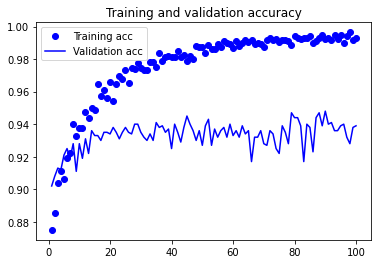

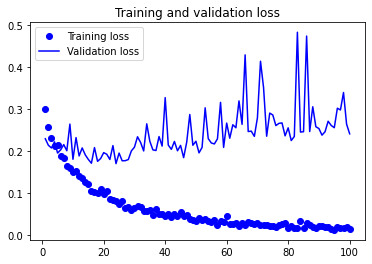

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

print("Accuracy: ", acc[-1])
print("Validation accuracy: ", val_acc[-1])
print("\n")
print("Loss: ", loss[-1])
print("Validation loss: ", val_loss[-1])

Accuracy:  0.9929999709129333
Validation accuracy:  0.9390000104904175


Loss:  0.015981895849108696
Validation loss:  0.24117812514305115


#Finally
We test on the test dataset

In [45]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20, 
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test accuracy:', test_acc)

Found 1000 images belonging to 2 classes.
Test accuracy: 0.9409999847412109


#Testing our pre-trained model

In [46]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [47]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

image_path = '/content/drive/My Drive/Image Datasets/random_pictures/sample_cat.jpeg'
img = image.load_img(image_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = preprocess_input(x)

In [48]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n02971356', 'carton', 0.2219832), ('n02124075', 'Egyptian_cat', 0.19359447), ('n02123045', 'tabby', 0.08688784)]
